## Lesson 07

**Recap**

We wanted to interpolate a given $f \in C^{\circ} ([0,1])$ on a set of distinct $(n+1)$ non decreasing points $\{x_i\}_{i=0}^n$ with **the** polynomial of order $n$ passing through $(x_i, f(x_i))$. We used Lagrange basis to get a well conditioned matrix $B_{ij} p^j = f(x_i)$ where $B_{ij} = \bar{v_j}(x_i)$.

In general: $(\mathcal{L}f)(x) := B^{ij} f(x_j)\bar{v_i}(x)$, that is why we want $B_{ij} = \mathbf{I}$. Our choice has nothing to do with the properties of the polynomial we get in the end, we just want an easy implementation.

We then showed that, with $f \in C^{n+1} ([0,1])$:

$$
\forall x \in [0,1] \exists \xi \in (x_0, x_n) \, s.t. \, (f-\mathcal{L}f)(x) = \frac{1}{(n+1)!} f^{(n+1)}(\xi) \omega(x)
$$

where I make an error:

$$
||(f-\mathcal{L}f)(x)||_{L^{\infty}([0,1])} = \frac{1}{(n+1)!}|| f^{(n+1)}||_{L^{\infty}([0,1])} ||\omega(x)||_{L^{\infty}([0,1])}
$$

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
# Interval = [a,b]
a = 0
b = 1
Nplots = 1025
N = 3 # Degree of polinomial space -1

In [26]:
x = linspace(a,b,Nplots)
q = linspace (a,b,N) # Points of interpolation


In [27]:
def myplot(f, plotpoints=x, interpolationpoints=q):
    plot(interpolationpoints, f(interpolationpoints), 'or')
    plot (plotpoints, f(plotpoints))
# This function has the second and third parameters set to a default value.
# You can now use the function with just one argument.

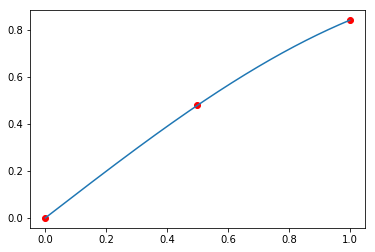

In [28]:
myplot(sin, x, q) # Or just myplot(sin) since x and q are the default values.

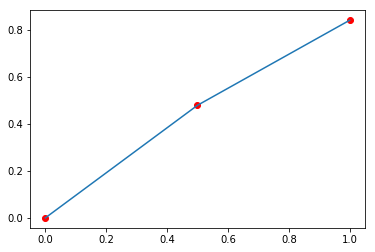

In [82]:
myplot(sin, q, q) # This plots straight lines between the points

Let's use the most simple basis. We should see that the $j$ columns (high powers) are going to look more and more similar:

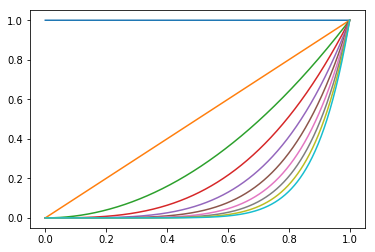

In [29]:
for i in range(10):
    plot(x, x**i)

We now want to produce the matrix $B^{ij}$. We can use broadcasts or for loops, which are easier but less efficient.

In [33]:
B = zeros((N,N))
B

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [35]:
I = arange(N)
I

array([0, 1, 2])

The most efficient way is:

In [39]:
B = q.reshape((N,1))**arange(N) # This is broadcasting. 
B
# This is creating two matrices from two vectors. The first is repeating columns, the second is repeating rows.
# The operation is then executed element by element.

array([[1.  , 0.  , 0.  ],
       [1.  , 0.5 , 0.25],
       [1.  , 1.  , 1.  ]])

Python sees $(N,1) * (N,)$ and:

 - $(N,1) * (1,N)$ firstly it transforms the vectors to be compatible;
 - $(N,N) * (N,N)$ then he creates two matrices, where the first matrix has equal rows, the second equal columns;

and lastly it performs an element-wise operation.

Or you can use for loops.

```
for j in range(N):
    B[:,j] = q**j # Actually this IS broadcasting.
```

Which produces the same result as:

```
for i in range(N):
    for j in range(N):
        B[i,j] = q[i]**j
```
but is more efficient. This searches for the elements for every row and column. The first one does it only for every row.

In [40]:
C = inv(B) # We can invert the matrix like so.

In [41]:
B.dot(C) # It is supposed to return the Identity matrix

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [42]:
cond(B) # With N=15 it gets to ~10^{15}, which is quite huge.

15.099657722502098

Now let's solve the interpolation problem.

In [44]:
Xvec = x.reshape((-1,1)) # Note: -1 means that numpy will figure out a proper dimension to make the new
                         # shape compatible with the original.
Xvec

array([[0.00000000e+00],
       [9.76562500e-04],
       [1.95312500e-03],
       ...,
       [9.98046875e-01],
       [9.99023438e-01],
       [1.00000000e+00]])

In [48]:
X = Xvec**I # This builds the x values for a N-1 degree polynomial, it uses broadcasting.
X

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.76562500e-04, 9.53674316e-07],
       [1.00000000e+00, 1.95312500e-03, 3.81469727e-06],
       ...,
       [1.00000000e+00, 9.98046875e-01, 9.96097565e-01],
       [1.00000000e+00, 9.99023438e-01, 9.98047829e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [49]:
X.shape

(1025, 3)

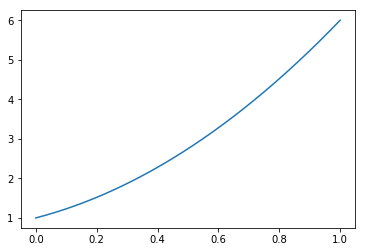

In [54]:
# if N=3 we want the polinomial 1+2*x+3*x^2.

p = array([1,2,3]) 
plot(Xvec, X.dot(p)) # The matrix-vector product creates the (1025,1) y values for a polynomial of order 2.

We now want to do the interpolation.

In [57]:
def myfun(x):
    return sin(2*pi*x)

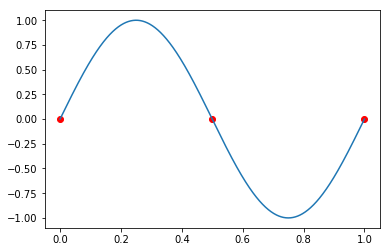

In [64]:
myplot(myfun)

Now I want to comput the polyomial that interpolates `myfun` on the $q$ points.

In [65]:
p = inv(B).dot(myfun(q)) # Theese are the values taken by the interpolating polynomial at the nodes q
p

array([ 0.00000000e+00,  7.34788079e-16, -9.79717439e-16])

(1025,)

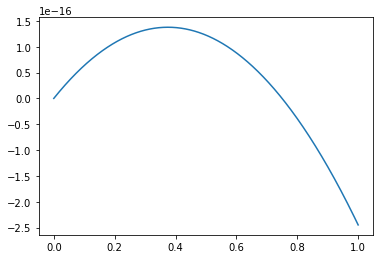

In [77]:
plot(Xvec, X.dot(p))
(X.dot(p)).shape # The 1025 y values the interpolating polynomial passing from q takes.

In [67]:
def interpolation(myfun, q, x):
    """Return the polynomial interpolation of myfun at the points q,
    evaluated at the points x.
    
    You can plot this by calling:
    
    plot(x, interpolation(myfun, q, x))
    """
    N = len(q)
    I = arange(N)
    Qvec = q.reshape((-1, 1)) # Vector of nodes
    Xvec = x.reshape((-1, 1)) # Vector of x values
    B = Qvec**I # Creates the Vandermond matrix
    V = Xvec**I # Creates the matrix of X values
    
    p = V.dot(inv(B).dot(myfun(q))) # Matrix of x values dot values taken by the polynomial => vector of y values
    
    return p

In [68]:
myf = lambda x : 1/(1+50*(x-.5)**2)

In [78]:
y = interpolation(myf, q, x)

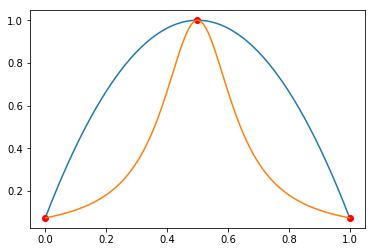

In [81]:
plot(x,y) # Interpolating function
plot(q, myf(q), 'or') # Nodes
plot(x, myf(x)) # Function to be interpolated

**EXERCISE: now implement the Lagrange interpolation**

Note: we are not computing the Lagrange basis explicitly, but inverting the Vandermond matrix.

In [71]:
def Lagrange_basis(q, x):
    """Returns the Lagreange basis function evaluated at x.
    The y values of the interpolating function can be obtained by:
    
    L.dot(myf(q)
    
    where myf() is the function to be interpolated.
    """
    
    N = len(q)
    I = arange(N)
    Qvec = q.reshape((-1, 1))
    Xvec = x.reshape((-1,1))
    B = Qvec**I
    V = Xvec**I
    
    L = V.dot(inv(B)) # Computes a change of basis from the power basis to the Lagrange one.
    
    return L

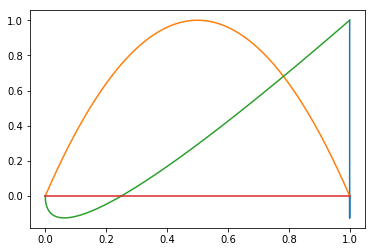

In [88]:
#L = Lagrange_basis(q,x)
#_ = plot(X,L)
#_ = plot(q, 0*q*1) I do not know what this is supposed to do. Should it plot the basis?

The interpolation using Lagrange polynomials returns the same results as before.

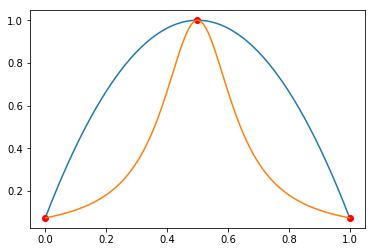

In [76]:
plot(x,L.dot(myf(q)))
plot(q, myf(q), 'or')
plot(x, myf(x))